최종 모델 학습 시작 (very_delay 가중치: 15)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2907
[LightGBM] [Info] Number of data points in the train set: 8024, number of used features: 74
[LightGBM] [Info] Start training from score -1.279544
[LightGBM] [Info] Start training from score -1.109894
[LightGBM] [Info] Start training from score -0.935876
학습 완료.


=== 최종 모델 성능 평가 (임계값: 0.3) ===
                 precision    recall  f1-score   support

 not_delay(<15)       0.85      0.56      0.68       880
   delay(15-60)       0.70      0.88      0.78      1043
very_delay(≥60)       0.54      0.73      0.62        83

       accuracy                           0.74      2006
      macro avg       0.70      0.73      0.69      2006
   weighted avg       0.76      0.74      0.73      2006



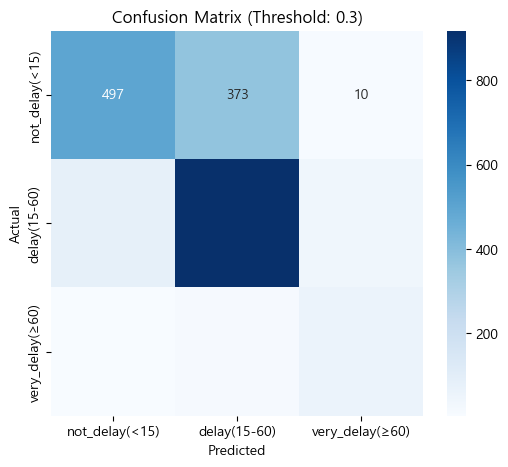

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import platform

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from lightgbm import LGBMClassifier
from sklearn.preprocessing import label_binarize

# ----------------------------
# 1. 폰트 설정
# ----------------------------
system_name = platform.system()
if system_name == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':  # Mac OS
    plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# ----------------------------
# 2. 데이터 로드 및 전처리
# ----------------------------
FILE_PATH = "FINAL_최종변수_추가.csv"
df = pd.read_csv(FILE_PATH, encoding='utf-8')

# 날짜 변수 추가
df['Date'] = pd.to_datetime(df[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))
df['day_of_week'] = df['Date'].dt.dayofweek
kr_holidays = holidays.KR()
df['is_holiday'] = df['Date'].apply(lambda x: x in kr_holidays).astype(int)
df = df.drop(columns=['Date'])

# Target/Feature 정의
# delay_min → 구간화해서 클래스 레이블 생성
bins = [float("-inf"), 15, 60, float("inf")]
labels = [0, 1, 2]  # 0=비지연, 1=지연, 2=매우지연
df['target'] = pd.cut(df['delay_min'], bins=bins, labels=labels, right=False).astype(int)

y = df['target'].values
X = df.drop(columns=['delay_min', 'STD', 'target'])

# 숫자/범주형 분리
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# OHE 함수 (버전 호환성)
def make_ohe():
    try:
        return OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    except TypeError:
        return OneHotEncoder(sparse=False, handle_unknown="ignore")

# 전처리 파이프라인
num_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("anova", SelectKBest(score_func=f_classif, k=30))
])
cat_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", make_ohe())
])
preprocess = ColumnTransformer(
    [("num", num_tf, num_cols), ("cat", cat_tf, cat_cols)],
    remainder="drop"
)

# ----------------------------
# 3. 학습/검증 데이터 분리
# ----------------------------
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# ----------------------------
# 4. 모델 학습 (가중치 적용)
# ----------------------------
best_weight = 15
print(f"최종 모델 학습 시작 (very_delay 가중치: {best_weight})")

# 클래스별 가중치 (여기서는 매우지연=2에 15배 가중치)
sample_weights = np.array([best_weight if yi == 2 else 1 for yi in y_tr])

final_model = Pipeline([
    ("preprocess", preprocess),
    ("clf", LGBMClassifier(
        objective="multiclass",
        num_class=3,
        random_state=42,
        n_jobs=-1
    ))
])
final_model.fit(X_tr, y_tr, clf__sample_weight=sample_weights)
print("학습 완료.")

# ----------------------------
# 5. 예측 확률을 이용한 임계값 조정 및 평가
# ----------------------------
# 1. 각 클래스에 대한 예측 확률 얻기
y_prob = final_model.predict_proba(X_va)

# 2. 새로운 임계값 설정 (이 값을 0.2 ~ 0.4 사이에서 조절해보세요)
custom_threshold = 0.3

# 3. 임계값 적용하여 최종 예측 생성
# 일단 가장 확률이 높은 클래스로 예측
y_pred_tuned = np.argmax(y_prob, axis=1)
# '매우 지연'(class 2)의 확률이 우리가 정한 임계값을 넘으면, 예측을 강제로 2로 변경
y_pred_tuned[y_prob[:, 2] > custom_threshold] = 2

# 4. 조정된 예측 결과로 성능 평가
print(f"\n\n=== 최종 모델 성능 평가 (임계값: {custom_threshold}) ===")
target_names = ["not_delay(<15)", "delay(15-60)", "very_delay(≥60)"]
print(classification_report(y_va, y_pred_tuned, target_names=target_names, zero_division=0))

# 혼동행렬 시각화
cm = confusion_matrix(y_va, y_pred_tuned)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold: {custom_threshold})")
plt.show()


SelectKBest에 의해 선택된 숫자형 피처 개수: 30

모델에 가장 큰 영향을 미치는 상위 20개 피처:
                         Feature  Importance
27        prev_flights_avg_delay         916
1                         기온(°C)         762
26        route_congestion_index         739
7                      이슬점온도(°C)         572
9                 풍속*sin(풍향-활주로)         549
15                          hour         489
17                      운행 위험 지수         418
28             congestion_x_wind         416
29  congestion_x_visibility_risk         413
25         flights_per_day_route         396
2                    10분평균풍속(KT)         368
3                   10분평균풍향(deg)         288
16                          테일윈드         271
0                           year         262
22                     풍향-활주로_편차         198
23              congestion_index         196
19                      날씨 강도 지수         195
5                       전운량(1/8)         171
6                          1층 운형         147
24               flight_sequence     

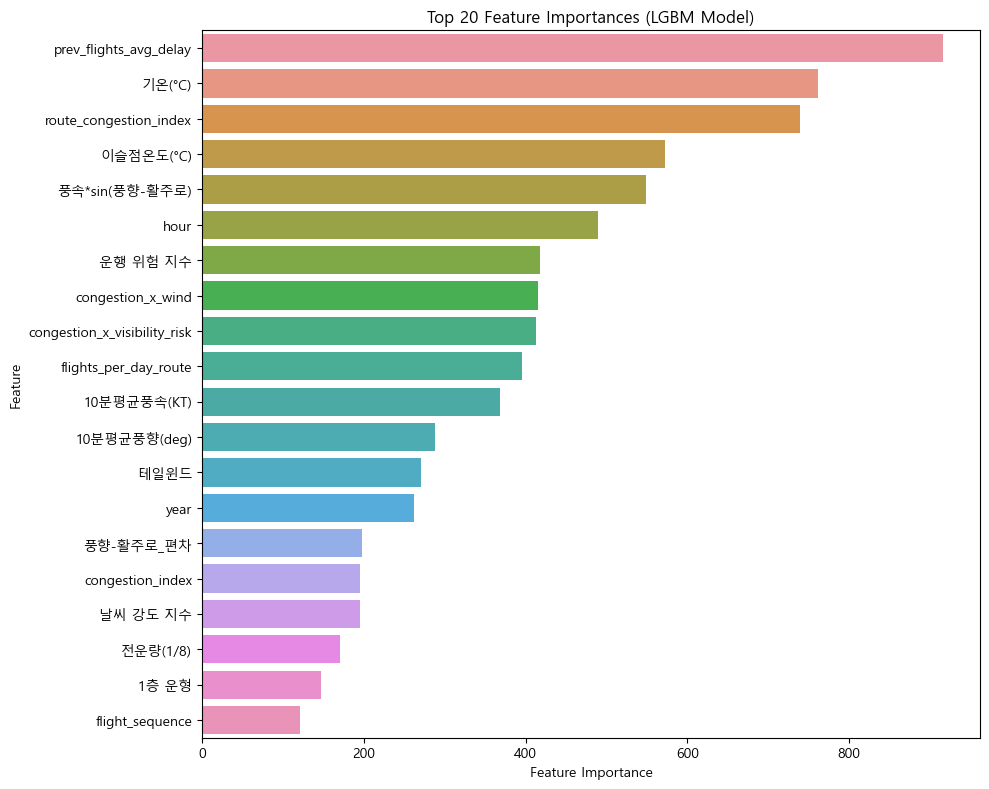


상위 20개 피처의 중요도 시각화가 완료되었습니다.


In [2]:
import shap  # SHAP 라이브러리 (정확한 피처 이름 추출을 위해 계속 사용)
import matplotlib.pyplot as plt

# ----------------------------
# 1. 피처 이름 추출 (모델 학습 후에 실행)
# ----------------------------

# 전처리 파이프라인에서 각 변환기 추출
preprocessor = final_model.named_steps['preprocess']

# 1. 숫자형 피처 이름 (SelectKBest의 결과를 포함하지 않는 '원래' 숫자형 컬럼 이름)
# NOTE: 현재 파이프라인은 최종적으로 SelectKBest를 사용하지 않으므로 모든 Num_cols를 처리합니다.
# 하지만 SelectKBest가 포함된 Num_tf가 전체 파이프라인에 들어가 있으므로,
# 실제 학습에 사용된 피처 개수를 정확히 알아야 합니다.

# SelectKBest가 포함된 num_tf를 학습 데이터로 fit하여 선택된 피처를 확인합니다.
# (원래 코드에서 이 부분이 누락되었으므로, 여기서 fit을 수행합니다. 
# 하지만 이미 final_model.fit에서 내부적으로 fit이 완료되었을 수 있으므로, 
# ColumnTransformer 내부의 SelectKBest 상태를 확인합니다.)

num_transformer = preprocessor.named_transformers_['num']
# num_transformer는 SimpleImputer, StandardScaler, SelectKBest를 포함하는 Pipeline입니다.
anova_step = num_transformer.named_steps['anova']

# anova_step이 fit되었는지 확인하고, 선택된 인덱스 가져오기
selected_num_indices = anova_step.get_support(indices=True)
selected_num_cols = [num_cols[i] for i in selected_num_indices]
print(f"SelectKBest에 의해 선택된 숫자형 피처 개수: {len(selected_num_cols)}")


# 2. 범주형 OHE 피처 이름 추출
cat_transformer = preprocessor.named_transformers_['cat']
ohe_step = cat_transformer.named_steps['ohe']
# OHE가 학습된 범주 목록을 사용하여 피처 이름을 생성합니다.
ohe_feature_names = ohe_step.get_feature_names_out(cat_cols)

# 최종 피처 이름 목록: ColumnTransformer의 순서에 따라 합칩니다.
# 주의: num_tf가 SelectKBest를 포함하므로, '선택된' 숫자 피처 이름만 사용합니다.
all_feature_names = selected_num_cols + list(ohe_feature_names)
N_FEATURES_USED = len(all_feature_names)


# ----------------------------
# 2. 피처 중요도 계산 및 정렬
# ----------------------------
classifier = final_model.named_steps['clf']
feature_importances = classifier.feature_importances_

if len(feature_importances) != N_FEATURES_USED:
    print("\n🚨 경고: LGBM 중요도 배열 크기가 최종 피처 이름 목록 크기와 다릅니다!")
    print(f"LGBM 중요도 크기: {len(feature_importances)}, 예상 크기: {N_FEATURES_USED}")
    # 이 경우, SelectKBest가 파이프라인 내부에서 예상과 다르게 동작했거나,
    # OHE 과정에서 문제가 발생했을 가능성이 높습니다.
    # 안전을 위해 예상 크기만큼만 사용하거나, 코드를 중단해야 합니다.
    # 여기서는 적절한 길이만큼 자릅니다.
    feature_importances = feature_importances[:N_FEATURES_USED]
    

# 피처 이름과 중요도를 DataFrame으로 결합
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# 중요도 순으로 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 상위 20개 피처 선택
top_20_features = importance_df.head(20)

print(f"\n모델에 가장 큰 영향을 미치는 상위 20개 피처:")
print(top_20_features)


# ----------------------------
# 3. 상위 20개 피처 시각화
# ----------------------------
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features)
plt.title('Top 20 Feature Importances (LGBM Model)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n상위 20개 피처의 중요도 시각화가 완료되었습니다.")


=== SHAP 분석 시작 ===

Shape of shap_values_raw: (1000, 148, 3)
Shape of sample_data: (1000, 148)

=== SHAP for class 0: not_delay(<15) ===


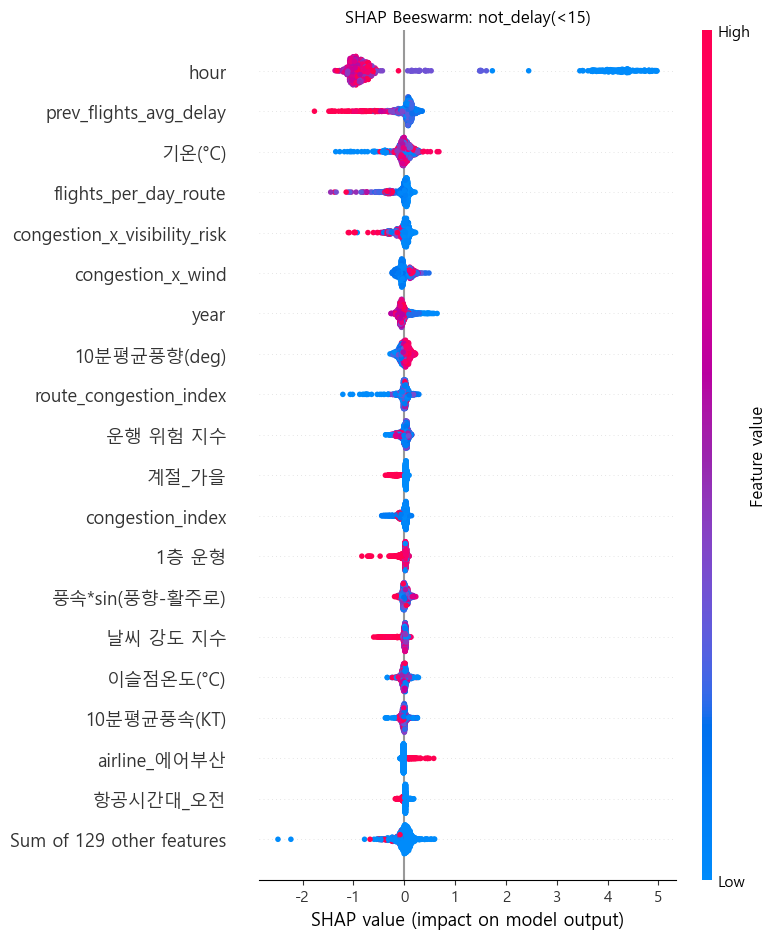

not_delay(<15)에 대한 플롯 생성이 완료되었습니다.

=== SHAP for class 1: delay(15-60) ===


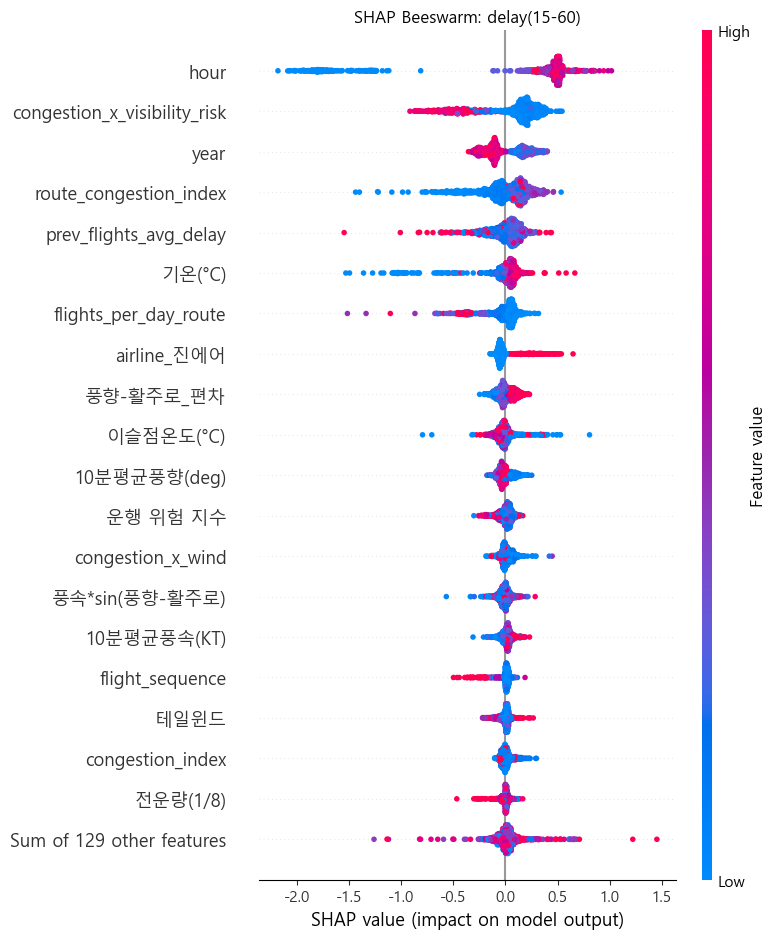

delay(15-60)에 대한 플롯 생성이 완료되었습니다.

=== SHAP for class 2: very_delay(≥60) ===


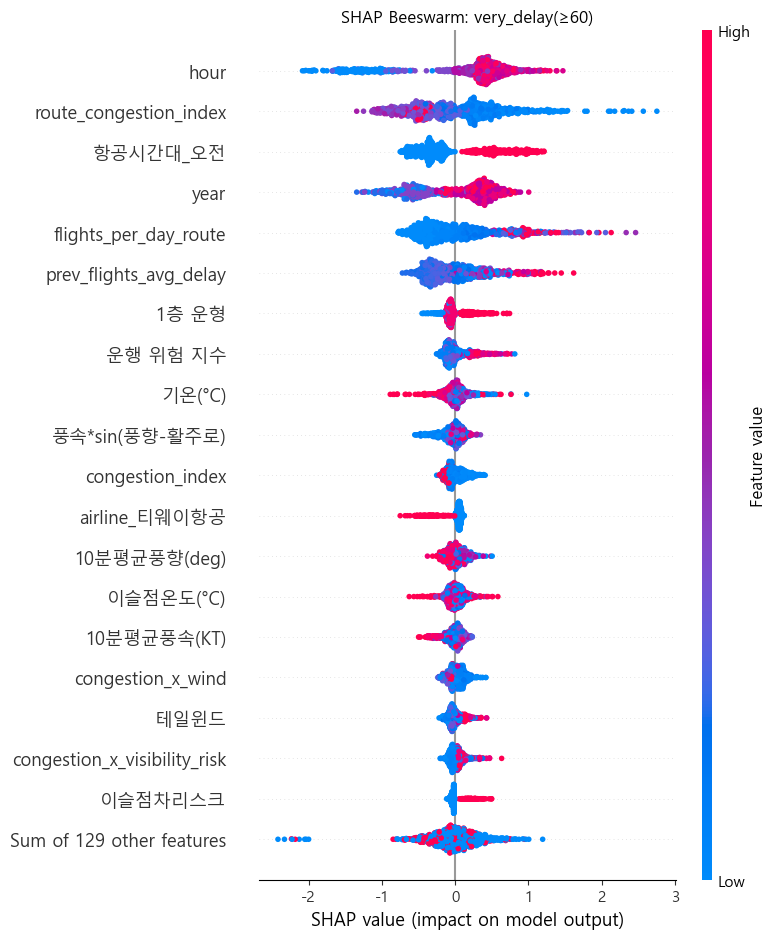

very_delay(≥60)에 대한 플롯 생성이 완료되었습니다.


In [3]:
# ----------------------------
# 5. SHAP 분석 (문제가 해결된 최종 버전)
# ----------------------------
print("\n=== SHAP 분석 시작 ===")

# SHAP Explainer 객체 생성
model = final_model.named_steps['clf']
explainer = shap.TreeExplainer(model)

# 전처리된 데이터셋 준비
preprocessor = final_model.named_steps['preprocess']
num_features_after_anova = preprocessor.named_transformers_['num'].named_steps['anova'].get_feature_names_out(num_cols)
ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(cat_cols)
feature_names = list(num_features_after_anova) + list(ohe_feature_names)

X_va_transformed = preprocessor.transform(X_va)
X_va_transformed_df = pd.DataFrame(X_va_transformed, columns=feature_names)

# SHAP 값 계산 (샘플 수를 500으로 줄여 메모리 문제 완화)
sample_data = X_va_transformed_df.sample(n=1000, random_state=42)
shap_values_raw = explainer.shap_values(sample_data)

# SHAP 값과 데이터의 shape 및 타입을 확인 (디버깅 목적)
print(f"\nShape of shap_values_raw: {np.array(shap_values_raw).shape}")
print(f"Shape of sample_data: {sample_data.shape}")

# shap_values의 차원을 (classes, samples, features)로 재구성합니다.
if isinstance(shap_values_raw, list):
    shap_values_corrected = np.array(shap_values_raw)
else:
    # SHAP이 (샘플, 피처, 클래스) 형태로 반환하는 경우
    shap_values_corrected = np.transpose(shap_values_raw, (2, 0, 1))

# 모든 클래스에 대한 SHAP 플롯 생성
target_names = ["not_delay(<15)", "delay(15-60)", "very_delay(≥60)"]
for i, class_name in enumerate(target_names):
    print(f"\n=== SHAP for class {i}: {class_name} ===")

    # --- Beeswarm Plot ---
    plt.figure()
    expl = shap.Explanation(
        values=shap_values_corrected[i],
        data=sample_data,
        feature_names=feature_names
    )
    shap.plots.beeswarm(expl, max_display=20, show=False)
    plt.title(f"SHAP Beeswarm: {class_name}")
    plt.tight_layout()
    # 플롯을 이미지 파일로 저장
    plt.savefig(f"shap_beeswarm_{i}_{class_name.replace('<', '').replace('>', '').replace('=', '').replace(' ', '_')}.png")
    plt.show()

    # 메모리 정리
    plt.close('all')
    print(f"{class_name}에 대한 플롯 생성이 완료되었습니다.")